In [111]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk
import json

In [18]:
train_json_data = json.load(open('train.json'))
train_df = pandas.json_normalize(train_json_data)

test_json_data = json.load(open('test.json'))
test_df = pandas.json_normalize(test_json_data)

In [54]:
train_df.columns

Index(['giver_username_if_known',
       'number_of_downvotes_of_request_at_retrieval',
       'number_of_upvotes_of_request_at_retrieval', 'post_was_edited',
       'request_id', 'request_number_of_comments_at_retrieval', 'request_text',
       'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_account_age_in_days_at_retrieval',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_days_since_first_post_on_raop_at_retrieval',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_comments_in_raop_at_retrieval',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_at_retrieval',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_posts_on_raop_at_retrieval',
       'requester_number_of_subreddits_at_request', 'r

## giver_username_if_known
Reddit username of giver if known, i.e. the person satisfying the request ("N/A" otherwise).

Notes:

There are 3753 N/A values. There are 250 unique values. 225 values only appear once. 1 username appears 5 times, 2 usernames appear 4 times, 3 usernames appear 3 times, and 2 usernames appear 16 times.
N/A usernames contains those who received pizza and those who did not. So N/A is not an indicator of whether the post did not get a pizza.

In [132]:
# number of unique values
# number of most frequently appearing username (which is N/A)
train_df.giver_username_if_known.describe()

count     4040
unique     250
top        N/A
freq      3753
Name: giver_username_if_known, dtype: object

In [145]:
# number of giver usernames that only show up once
giver_username_counts = train_df.giver_username_if_known.value_counts()
giver_username_counts[giver_username_counts == 1].shape

(225,)

In [141]:
# look at usernames that show up more than 1 time
giver_username_counts[giver_username_counts > 1]

N/A                     3753
jetboyterp                 5
m2nu                       4
johngalt1337               4
thr                        4
mr_jeep                    4
glinda_da_good_witch       3
pizzamom                   3
leftnewdigg                3
bgoodrbcareful             2
pastafariantwit            2
dezmodez                   2
boatdude                   2
idtugyourboat              2
kramapple                  2
harrisonfire               2
zandyman                   2
olivertw1st                2
psm321                     2
ladyjanegr                 2
govalle                    2
foki                       2
whosthatguru_v2            2
fogdelune                  2
jabberworx                 2
Name: giver_username_if_known, dtype: int64

In [128]:
# how many requests got a pizza with a giver who's user_name is N/A
train_df.requester_received_pizza[train_df.giver_username_if_known == 'N/A'].value_counts()

False    3046
True      707
Name: requester_received_pizza, dtype: int64

## requester_number_of_comments_in_raop_at_request
Total number of comments in RAOP by requester at time of request.

Notes:
The range is 0 to 88 comments. The majority of requestors have 0 ROAP comments before placing a request in ROAP (n = 3453).

23% of those with 0 ROAP comments got a pizza. 37% of those with at least one ROAP comment got a pizza.

Have those with no comments separate from those with comments

In [178]:
print(train_df.requester_number_of_comments_in_raop_at_request.describe())
# print(train_df.requester_number_of_comments_in_raop_at_request.value_counts())
print(train_df.requester_number_of_comments_in_raop_at_request.value_counts()[:5])
print(train_df.requester_number_of_comments_in_raop_at_request.value_counts()[-5:])


count    4040.000000
mean        0.645050
std         3.413813
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        88.000000
Name: requester_number_of_comments_in_raop_at_request, dtype: float64
0    3453
1     240
2      98
3      61
4      49
Name: requester_number_of_comments_in_raop_at_request, dtype: int64
17    1
21    1
33    1
43    1
88    1
Name: requester_number_of_comments_in_raop_at_request, dtype: int64


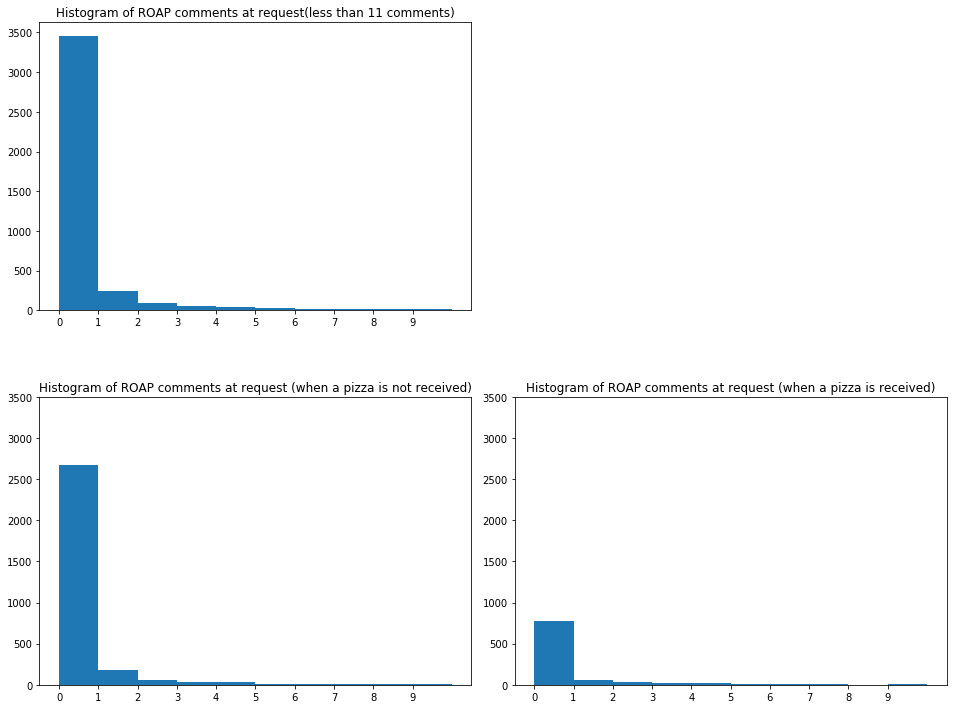

In [236]:
# plotting distribution of ROAP comments
fig = plt.figure()
axes1 = fig.add_axes([0.1,0.1,1,1]) # main axes
axes2 = fig.add_axes([1.2,-1.2,1,1])
axes3 = fig.add_axes([0.1,-1.2,1,1])

axes1.hist(train_df.requester_number_of_comments_in_raop_at_request[train_df.requester_number_of_comments_in_raop_at_request <11])
axes1.set_title("Histogram of ROAP comments at request(less than 11 comments)")
axes1.set_yticks(range(0,4000, 500))
axes1.set_xticks(range(0,10, 1))

# plotting distribution of ROAP comments when someone received a pizza
axes2.hist(train_df.requester_number_of_comments_in_raop_at_request[(train_df.requester_received_pizza == 1) & (train_df.requester_number_of_comments_in_raop_at_request <11)])
axes2.set_title("Histogram of ROAP comments at request (when a pizza is received)")
axes2.set_yticks(range(0,4000, 500))
axes2.set_xticks(range(0,10, 1))

# plotting distribution of ROAP comments when someone did not receive a pizza
axes3.hist(train_df.requester_number_of_comments_in_raop_at_request[(train_df.requester_received_pizza == 0) & (train_df.requester_number_of_comments_in_raop_at_request <11)])
axes3.set_title("Histogram of ROAP comments at request (when a pizza is not received)")
axes3.set_yticks(range(0,4000, 500))
axes3.set_xticks(range(0,10, 1))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fbb5925f710>,
 'caps': [<matplotlib.lines.Line2D at 0x7fbb59266d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fbb5925f6d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fbb593fc810>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fbb593fcd10>,
 'means': []}

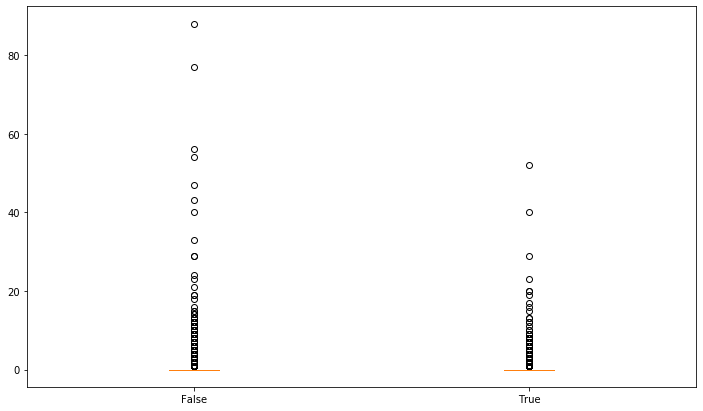

In [254]:
# plotting log transformed feature
num_roap_comments_pizza = train_df[train_df['requester_received_pizza'] == True]['requester_number_of_comments_in_raop_at_request']
num_roap_comments_no_pizza = train_df[train_df['requester_received_pizza'] == False]['requester_number_of_comments_in_raop_at_request']

set_to_plot = [num_roap_comments_pizza, num_roap_comments_no_pizza]
labels = train_df['requester_received_pizza'].unique()

fig, ax = plt.subplots(figsize=(12, 7))
ax.boxplot(set_to_plot, labels=labels)

In [201]:
# now using buckets ROAP comments
train_df['roap_comments_start_bucketed'] = np.where(train_df.requester_number_of_comments_in_raop_at_request >= 1, 1, 0)
pd.crosstab(train_df.requester_received_pizza, train_df.roap_comments_start_bucketed)


roap_comments_start_bucketed,0,1
requester_received_pizza,,
False,2674,372
True,779,215


In [186]:
# seeing number of requestors by whether they got a pizza and number of ROAP comments
pd.crosstab(train_df.requester_received_pizza, pd.cut(train_df.requester_number_of_comments_in_raop_at_request, 90)) 

requester_number_of_comments_in_raop_at_request,"(-0.088, 0.978]","(0.978, 1.956]","(1.956, 2.933]","(2.933, 3.911]","(3.911, 4.889]","(4.889, 5.867]","(5.867, 6.844]","(6.844, 7.822]","(7.822, 8.8]","(8.8, 9.778]",...,"(28.356, 29.333]","(32.267, 33.244]","(39.111, 40.089]","(42.044, 43.022]","(46.933, 47.911]","(51.822, 52.8]","(53.778, 54.756]","(55.733, 56.711]","(76.267, 77.244]","(87.022, 88.0]"
requester_received_pizza,,,,,,,,,,,,,,,,,,,,,
False,2674,176,63,38,30,14,10,8,13,3,...,1,0,1,0,0,1,0,0,0,0
True,779,64,35,23,19,12,7,5,3,6,...,2,1,1,1,1,0,1,1,1,1


In [252]:
# transforming feature with log
train_df['num_roap_comments_log'] = np.log(train_df.requester_number_of_comments_in_raop_at_request + 0.00001)

Text(0.5, 1.0, 'Number of log ROAP Comments by whether they received a pizza')

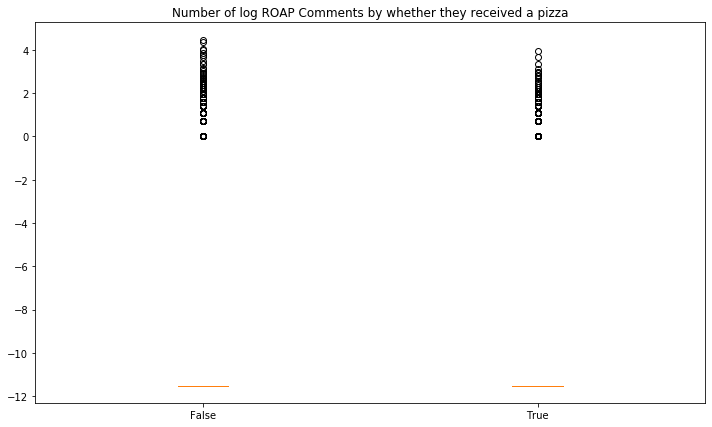

In [271]:
# plotting log transformed feature
num_roap_comments_log_pizza = train_df[train_df['requester_received_pizza'] == True]['num_roap_comments_log']
num_roap_comments_log_no_pizza = train_df[train_df['requester_received_pizza'] == False]['num_roap_comments_log']

set_to_plot = [num_roap_comments_log_pizza, num_roap_comments_log_no_pizza]
labels = train_df['requester_received_pizza'].unique()

fig, ax = plt.subplots(figsize=(12, 7))
ax.boxplot(set_to_plot, labels=labels)
ax.set_title('Number of log ROAP Comments by whether they received a pizza')

In [267]:
# creating new variable for those with no comments 
train_df['no_roap_comments'] = np.where(train_df['requester_number_of_comments_in_raop_at_request'] == 0, True, False)

Text(0.5, 1.0, 'Number of ROAP Comments (at least 1) by whether they received a pizza')

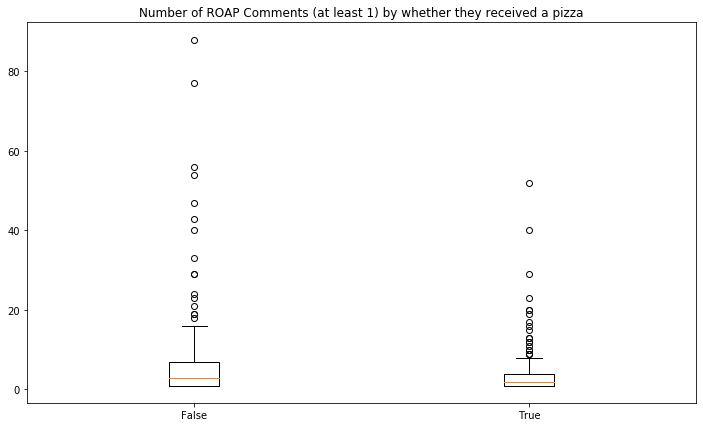

In [266]:
# plotting without those who had zero comments
num_roap_comments_pizza = train_df[(train_df['requester_received_pizza'] == True) & (train_df['no_roap_comments'] == False)]['requester_number_of_comments_in_raop_at_request']
num_roap_comments_no_pizza = train_df[(train_df['requester_received_pizza'] == False) & (train_df['no_roap_comments'] == False)]['requester_number_of_comments_in_raop_at_request']

set_to_plot = [num_roap_comments_pizza, num_roap_comments_no_pizza]
labels = train_df['requester_received_pizza'].unique()

fig, ax = plt.subplots(figsize=(12, 7))
ax.boxplot(set_to_plot, labels=labels)
ax.set_title('Number of ROAP Comments (at least 1) by whether they received a pizza')

Text(0.5, 1.0, 'Number of log ROAP Comments (at least 1) by whether they received a pizza')

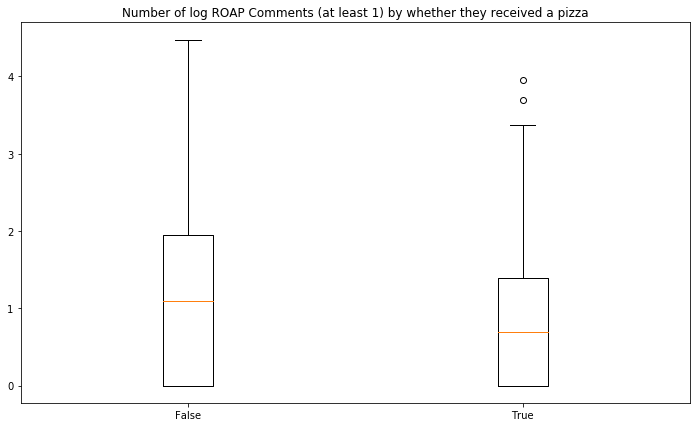

In [273]:
# plotting without those who had zero comments
num_roap_comments_pizza = train_df[(train_df['requester_received_pizza'] == True) & (train_df['no_roap_comments'] == False)]['num_roap_comments_log']
num_roap_comments_no_pizza = train_df[(train_df['requester_received_pizza'] == False) & (train_df['no_roap_comments'] == False)]['num_roap_comments_log']

set_to_plot = [num_roap_comments_pizza, num_roap_comments_no_pizza]
labels = train_df['requester_received_pizza'].unique()

fig, ax = plt.subplots(figsize=(12, 7))
ax.boxplot(set_to_plot, labels=labels)
ax.set_title('Number of log ROAP Comments (at least 1) by whether they received a pizza')


## requester_number_of_posts_at_request
Total number of posts on Reddit by requester at time of request.

Notes:
The range is 0 to 867 Reddit post. About 1198 requestors have 0 post on Reddit. Half of the requesters have 5 or less Reddit posts. Since the mean is so high (esp compared to the median) there must be outliers which are people who are very very active Reddit posters. 

19% of those with 0 Reddit posts got a pizza. 27% of those who have >0 Reddit posts got a pizza.


In [209]:
print(train_df.requester_number_of_posts_at_request.describe())
# print(train_df.requester_number_of_posts_at_request.value_counts())
print(train_df.requester_number_of_posts_at_request.value_counts()[:5])
print(train_df.requester_number_of_posts_at_request.value_counts()[-5:])

count    4040.000000
mean       21.601485
std        50.895060
min         0.000000
25%         0.000000
50%         5.000000
75%        22.000000
max       867.000000
Name: requester_number_of_posts_at_request, dtype: float64
0    1198
1     293
2     218
3     167
4     131
Name: requester_number_of_posts_at_request, dtype: int64
586    1
594    1
809    1
824    1
612    1
Name: requester_number_of_posts_at_request, dtype: int64


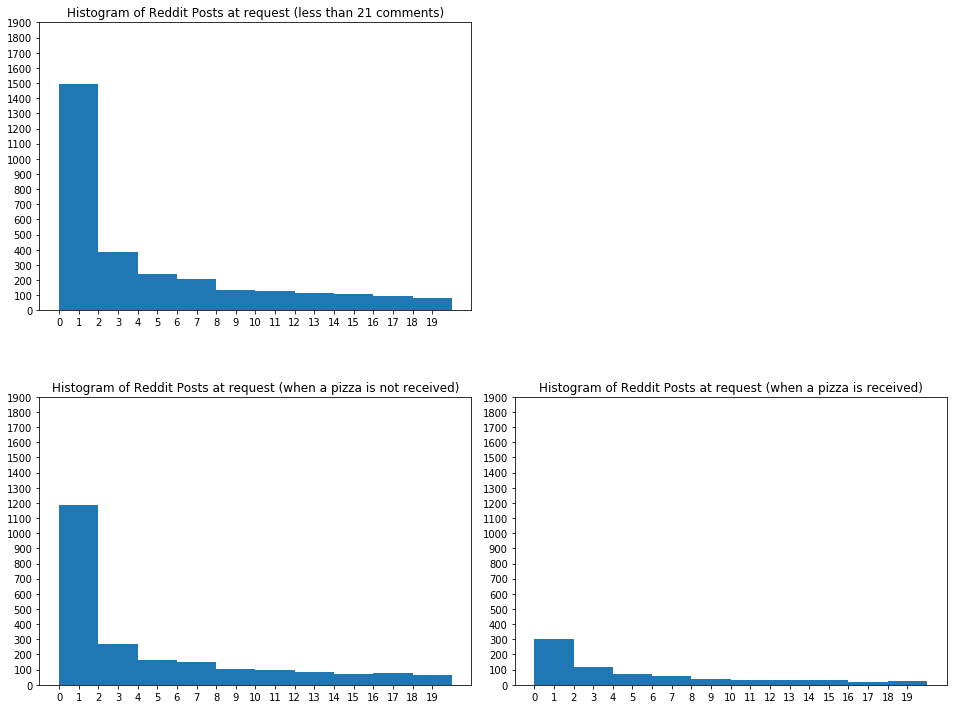

In [228]:
# plotting distribution of Reddit Posts
fig = plt.figure()
axes1 = fig.add_axes([0.1,0.1,1,1]) # main axes
axes2 = fig.add_axes([1.2,-1.2,1,1])
axes3 = fig.add_axes([0.1,-1.2,1,1])

axes1.hist(train_df.requester_number_of_posts_at_request[train_df.requester_number_of_posts_at_request <21])
axes1.set_title("Histogram of Reddit Posts at request (less than 21 comments)")
axes1.set_yticks(range(0,2000, 100))
axes1.set_xticks(range(0,20, 1))

# plotting distribution of Reddit Posts when someone received a pizza
axes2.hist(train_df.requester_number_of_posts_at_request[(train_df.requester_received_pizza == 1) & (train_df.requester_number_of_posts_at_request <21)])
axes2.set_title("Histogram of Reddit Posts at request (when a pizza is received)")
axes2.set_yticks(range(0,2000, 100))
axes2.set_xticks(range(0,20, 1))

# plotting distribution of Reddit Posts when someone did not receive a pizza
axes3.hist(train_df.requester_number_of_posts_at_request[(train_df.requester_received_pizza == 0) & (train_df.requester_number_of_posts_at_request <21)])
axes3.set_title("Histogram of Reddit Posts at request (when a pizza is not received)")
axes3.set_yticks(range(0,2000, 100))
axes3.set_xticks(range(0,20,1))

In [213]:
# now using buckets Reddit posts start
train_df['reddit_posts_start_bucketed'] = np.where(train_df.requester_number_of_posts_at_request >= 1, 1, 0)
pd.crosstab(train_df.requester_received_pizza, train_df.reddit_posts_start_bucketed)


reddit_posts_start_bucketed,0,1
requester_received_pizza,,
False,967,2079
True,231,763


In [223]:
# seeing number of requestors by whether they got a pizza and number of Reddit posts at start
pd.crosstab(train_df.requester_received_pizza, pd.cut(train_df.requester_number_of_posts_at_request, 20)) 


requester_number_of_posts_at_request,"(-0.867, 43.35]","(43.35, 86.7]","(86.7, 130.05]","(130.05, 173.4]","(173.4, 216.75]","(216.75, 260.1]","(260.1, 303.45]","(303.45, 346.8]","(346.8, 390.15]","(390.15, 433.5]","(433.5, 476.85]","(476.85, 520.2]","(563.55, 606.9]","(606.9, 650.25]","(780.3, 823.65]","(823.65, 867.0]"
requester_received_pizza,,,,,,,,,,,,,,,,
False,2639,238,75,47,17,9,6,1,6,1,1,2,1,0,1,2
True,838,98,27,11,5,8,0,3,1,0,0,0,1,2,0,0


{'whiskers': [<matplotlib.lines.Line2D at 0x7fbb59e0acd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fbb59e0aa90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fbb59e0ac90>,
 'medians': [<matplotlib.lines.Line2D at 0x7fbb59f42dd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fbb59f39ed0>,
 'means': []}

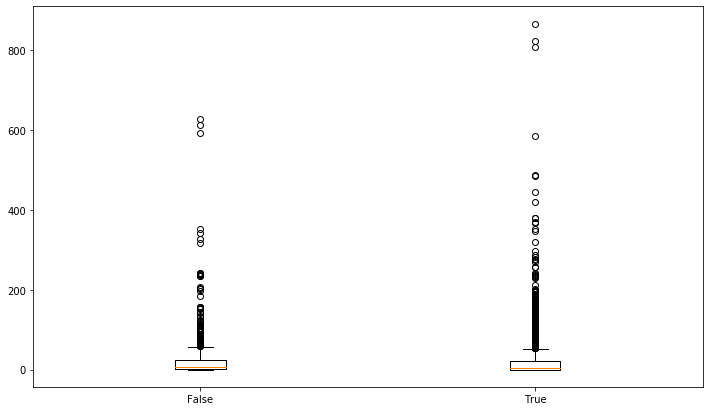

In [270]:
# plotting feature
num_posts_pizza = train_df[train_df['requester_received_pizza'] == True]['requester_number_of_posts_at_request']
num_posts_no_pizza = train_df[train_df['requester_received_pizza'] == False]['requester_number_of_posts_at_request']

set_to_plot = [num_posts_pizza, num_posts_no_pizza]
labels = train_df['requester_received_pizza'].unique()

fig, ax = plt.subplots(figsize=(12, 7))
ax.boxplot(set_to_plot, labels=labels)

In [272]:
# transforming feature with log
train_df['num_posts_log'] = np.log(train_df['requester_number_of_posts_at_request'] + 0.00001)
# creating new variable for those with no posts 
train_df['no_posts'] = np.where(train_df['requester_number_of_comments_in_raop_at_request'] == 0, True, False)

Text(0.5, 1.0, 'Number of Reddit Posts (at least 1) by whether they received a pizza')

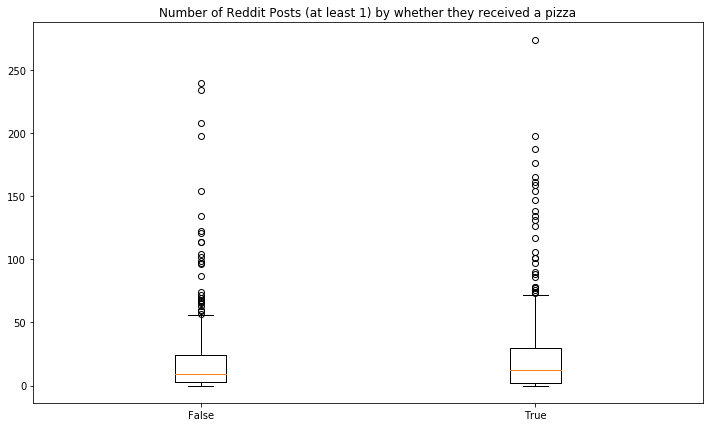

In [274]:
# plotting without those who had zero posts
num_posts_pizza = train_df[(train_df['requester_received_pizza'] == True) & (train_df['no_posts'] == False)]['requester_number_of_posts_at_request']
num_posts_no_pizza = train_df[(train_df['requester_received_pizza'] == False) & (train_df['no_posts'] == False)]['requester_number_of_posts_at_request']

set_to_plot = [num_posts_pizza, num_posts_no_pizza]
labels = train_df['requester_received_pizza'].unique()

fig, ax = plt.subplots(figsize=(12, 7))
ax.boxplot(set_to_plot, labels=labels)
ax.set_title('Number of Reddit Posts (at least 1) by whether they received a pizza')

Text(0.5, 1.0, 'Number of log Reddit Posts (at least 1) by whether they received a pizza')

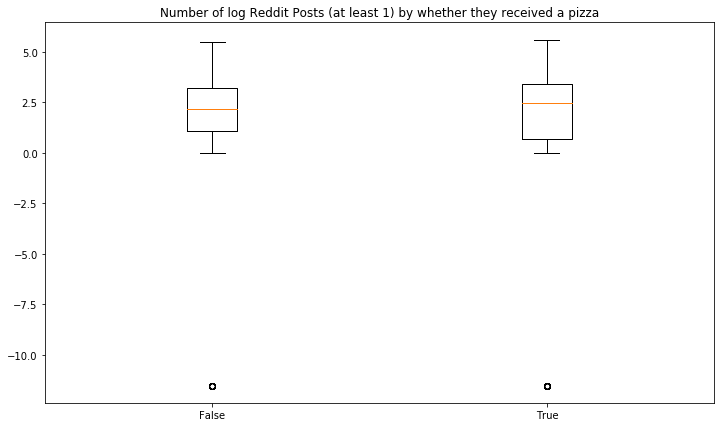

In [275]:
# plotting without those who had zero posts
num_log_posts_pizza = train_df[(train_df['requester_received_pizza'] == True) & (train_df['no_posts'] == False)]['num_posts_log']
num_log_posts_no_pizza = train_df[(train_df['requester_received_pizza'] == False) & (train_df['no_posts'] == False)]['num_posts_log']

set_to_plot = [num_log_posts_pizza, num_log_posts_no_pizza]
labels = train_df['requester_received_pizza'].unique()

fig, ax = plt.subplots(figsize=(12, 7))
ax.boxplot(set_to_plot, labels=labels)
ax.set_title('Number of log Reddit Posts (at least 1) by whether they received a pizza')